# DENUE Exploratory Data Analysis notebook

[DENUE](http://www.beta.inegi.org.mx/app/mapa/denue/) means Directorio Estadístico Nacional de Unidades Economicas. It is maintained by [INEGI](http://www.inegi.org.mx/), the Mexican Institute of Statistics and Geography.

In this notebook we start exploring the data as part of our project to map the creative industries in Mexico

## About the data

This [methodological note](http://www.beta.inegi.org.mx/app/biblioteca/ficha.html?upc=702825097240) describes the data (in Spanish).

DENUE contains information about ~5 million active businesses in Mexico. This includes:

* Identification
* Location
* Sector
* Size

DENUE’s first edition was published in 2010, with data collected in 2009. Individual entrepreneurs and organisations are legally required to register in DENUE and update their information. Other parts of the public sector are also required to provide INEGI with data to maintain DENUE. 

**Data updates**

* Information about larger businesses (>20 employees / $20m in turnover or activities in more than one State) as well as those in some sectors are updated yearly with administrative data and business surveys.

* Information about micro/small/medium businesses is partially updated through administrative registers.

* Users update their information online continuously, and this information is quality assured by INEGI.

* All data in DENUE are updated every 5 years through information produced by the economic census. The latest complete update of DENUE was in 2016, using data from the 2014 economic census.

### Conceptual framework and coverage

**Unit of analysis**

DENUE contains information about establishments (local units) and enterprises. 

**Sector**

DENUE contains information about all industries with the exception of agriculture, farming and forestry, transport, political organisations, domestic workers and extraterritorial units.

Industrial activities are classified according to 2013 NAICS. The first edition of DENUE using 2013 NAICs was in 2015 (*this means we can probably use definitions of the creative industries implemented by Nesta in its analysis of the creative industries in North America*)

**Period**

The period covered by business data depends on the year of incorporation.
  * For businesses incorporated before 2014, DENUE data refers to 2014
  * For businesses incorporated Jan 2015- Oct 2016 - DENUE data refers to 2015
  * For business incorporated Mar 2017-Nov 2017 - Data refers to 2016

**Geography**

DENUE includes economic units in locations with 2500+ inhabitants as well as ‘economic locations’ such as industrial parks. It doesn’t contain economic units in rural areas./

Data are available at the following levels of resolution:
* AGEE (States) - 2 digit based on State name. Administrative boundary
* AGEM (towns / cities) - 3 digits.
* AGEB (micro-geography):
  * Urban: 1-50 squares
  * Rural: ~11m Ha.

Longitude and Latitude data are also available. 

### Variables

* Nombre: Name. Some organisations have generic names.
* Denominación o razón social y tipo de sociedad: Type of organisation
* Código: industrial code based on NAICs (organisations are allocated to the sector which generates most turnover for the company)
* Personal: 8 sizebands (0-251+)
* Tipo de Unidad económica: 
  * Whether the organisation is a subsidiary, and the type of establishment.
* Datos de ubicación: Location (address)
* Area geográfica: (see above)
* Contact details:
  * Telephone
  * Web address
  * Email



## Some processing activities

* Load data
* Merge with creative NAICs codes
* Produce some descriptive analysis: creative sectors by location (totals, specialisation)
* Analyse access to contact details




## Preamble

This includes:

* Package imports
* Paths
* Functions and classes used below



In [440]:
%matplotlib inline

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Other imports 

#Zipfile to work with zips.
import zipfile

#Spacy and geopandas for spatial stuff
import spacy
import geopandas as gp

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data
ext_data = os.path.join(top,'data/external')

#Metadata
meta_data = os.path.join(top,'data/metadata')

#Interim data
int_data = os.path.join(top,'data/interim')

#Processed data
proc_data = os.path.join(top,'data/processed')

#Figures
fig_path = os.path.join(top,'reports/final_figures')

#Tables
tab_path = os.path.join(top,'reports/tables')

#Models
mod_path = os.path.join(top,'models')

#Visualisations
viz_path = os.path.join(top,'src/visualization')

#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

## 1. Load data

Here we will process all relevant DENUE files. There are quite a few of them and they are big. To deal with this I will write a class that loads them one at a time, unzips them, extracts companies in creative sectors (based on a lookup table based on NAICS codes) and generates some sector / area reports to normalise findings.


### a. Load metadata

Lookup between NAICs and creative industries codes based on Nesta 2016 (see Table A10 in /references folder)

Some of the codes in that table are too coarse (ie advertising also includes management consultancy). We have created a more refined classification that removes some of the non-creative subcodes, but we will generally work with Nesta's classification for consistency. It would be easy to replicate the analysis focusing on the refined categories


In [441]:
#Load a file with NAICs codes and info about whether they are creative or not
naics_creative_lookup = pd.read_csv(meta_data+'/naics_sics_creative_lookup.csv')

#Flag creative codes
naics_creative_lookup['has_creative'] = [1 if x==1 or y==1 else 0 for x,y in zip(
    naics_creative_lookup['creative_nesta_2016'],
    naics_creative_lookup['creative_refined'])]

#Focus on relevant codes
naics_creative_lookup_short = naics_creative_lookup.loc[
    naics_creative_lookup.has_creative==1,:].reset_index(drop=True)

#Turn codes into ints
naics_creative_lookup_short['code_int'] =[int(x) for x in naics_creative_lookup_short.code_es]

Load shapefiles for mapping. We downloaded them from [here](http://www.inegi.org.mx/geo/contenidos/geoestadistica/m_geoestadistico.aspx).

In [442]:
estados = gp.read_file(meta_data+'/inegi_shapefile/conjunto_de_datos/areas_geoestadisticas_estatales.shp')

#They were easy to load. We can use them below
estados.head()

,CVE_ENT,NOM_ENT,geometry
0,01,Aguascalientes,"POLYGON ((2470517.824301003 1155028.588319506,..."
1,02,Baja California,(POLYGON ((1073966.633401998 2349614.872239001...
2,03,Baja California Sur,(POLYGON ((1694656.344386794 1227647.637368001...
3,04,Campeche,(POLYGON ((3702830.927301012 1030965.603919527...
4,05,Coahuila de Zaragoza,"POLYGON ((2469954.193002 1978522.993039001, 24..."


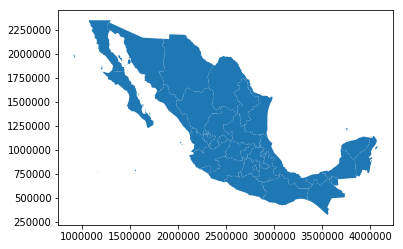

In [443]:
estados.plot()

### b. Load one file for exploration

In [444]:
#This creates the file. We will load one that has creative sectors in it
zf = zipfile.ZipFile(ext_data+'/sector_data/Actividad_económica.51_Información_en_medios_masivos.csv.zip')

#Extract the names
zf_names = zf.infolist()

print(zf_names)

[<ZipInfo filename='denue_00_51_csv/conjunto_de_datos/' external_attr=0x10>, <ZipInfo filename='denue_00_51_csv/conjunto_de_datos/denue_inegi_51_.csv' compress_type=deflate external_attr=0x20 file_size=8850882 compress_size=1894091>, <ZipInfo filename='denue_00_51_csv/diccionario_de_datos/' external_attr=0x10>, <ZipInfo filename='denue_00_51_csv/diccionario_de_datos/denue_diccionario_de_datos.csv' compress_type=deflate external_attr=0x20 file_size=9807 compress_size=3354>, <ZipInfo filename='denue_00_51_csv/metadatos/' external_attr=0x10>, <ZipInfo filename='denue_00_51_csv/metadatos/metadatos_denue.txt' compress_type=deflate external_attr=0x20 file_size=1987 compress_size=1055>]


#### Load the data dictionary

In [445]:
#Denue data dictionary

#This gets the filename for the data dictionary
data_dict_filename = zf_names[3].filename

#And we read it
denue_dictionary = pd.read_csv(zf.open(data_dict_filename))

#We save it so we can have a look at it, and maybe create cleaner names and variables
denue_dictionary.to_csv(meta_data+'/{date}_denue_data_dictionary.csv'.format(date=today_str))


#### Load the data

In [446]:
#We are interested in the 'denue_inegi_51_.csv' file, index=1
denue_data = zf_names[1]

#We get its name (which we will use to open the data)
denue_file_name = denue_data.filename

In [447]:
#Pandas can read this easily
denue_51 = pd.read_csv(zf.open(denue_file_name))

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [448]:
#Here it is
denue_51.head()

,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,localidad,ageb,manzana,telefono,correoelec,www,tipoUniEco,latitud,longitud,fecha_alta
0,17294,"ALESTRA, S. DE R.L. DE C.V.","ALESTRA, S. DE R.L. DE C.V.",517110,Operadores de servicios de telecomunicaciones ...,0 a 5 personas,AVENIDA,UNIVERSIDAD,AVENIDA,AGUASCALIENTES NORTE,...,Aguascalientes,2259,19,4.499228e+09,MPAVON@ALESTRA.COM.MX,WWW.ALESTRA.COM.MX,Fijo,21.916712,-102.313562,MARZO 2011
1,42915,ALMACÉN DISH,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",517910,Otros servicios de telecomunicaciones,51 a 100 personas,BOULEVARD,LICENCIADO MIGUEL DE LA MADRID,CALLE,LOS NARANJOS,...,Corral de Barrancos,043A,31,4.499943e+09,NaN,WWW.DISH.COM.MX,Fijo,21.949974,-102.332994,DICIEMBRE 2014
2,6506350,ALTARIA AGUASCALIENTES,"GRUPO IUSACELL, S.A. DE C.V.",517210,Operadores de servicios de telecomunicaciones ...,6 a 10 personas,CALLE,NINGUNO,NINGUNO,NINGUNO,...,Aguascalientes,1320,66,NaN,NaN,WWW.ATT.COM.MX,Fijo,21.925536,-102.289215,ENERO 2016
3,15779,ANIMACTIVA,NaN,511210,Edición de software y edición de software inte...,11 a 30 personas,CIRCUITO,HORTALIZAS,CALLE,FELIPE SERRANO,...,Aguascalientes,3098,7,4.491399e+09,cesar@animactiva.mx,www.animactiva.mx,Fijo,21.923799,-102.268272,JULIO 2010
4,20508,ARCHIVO GENERAL MUNICIPAL,PRESIDENCIA MUNICIPAL,519122,Bibliotecas y archivos del sector público,11 a 30 personas,CALLE,JUAN DE MONTORO,CALLE,JOSÉ MARÍA MORELOS Y PAVÓN,...,Aguascalientes,0638,6,4.499159e+09,MUNICIPAL@AGS.GOB.MX,WWW.AGS.GOB.MX/ARCHIVO,Fijo,21.881122,-102.293654,JULIO 2010


In [449]:
#It contains 19K obsrrvations and 41 variables
denue_51.shape

(19919, 41)

In [450]:
#These are the top 10 sectors
denue_51.nombre_act.value_counts()[:10]

Otros servicios de telecomunicaciones                                                 4518
Bibliotecas y archivos del sector público                                             4490
Operadores de servicios de telecomunicaciones alámbricas                              4082
Transmisión de programas de radio                                                     1241
Operadores de servicios de telecomunicaciones inalámbricas                             968
Exhibición de películas y otros materiales audiovisuales                               915
Edición de periódicos integrada con la impresión                                       727
Transmisión de programas de televisión                                                 396
Procesamiento electrónico de información, hospedaje y otros servicios relacionados     370
Edición de revistas y otras publicaciones periódicas                                   246
Name: nombre_act, dtype: int64

In [451]:
#What do the sector codes look like? Can we find them in the NAICs lookups

list(set(denue_51.codigo_act))[:5]

[512130, 511111, 511112, 515210, 511121]

They have 7 digits

In [452]:
#Check lookup. We do this by dropping duplicate codes in the data
code_name_lu = denue_51[['codigo_act','nombre_act']].drop_duplicates('codigo_act').reset_index(drop=True)

#We have compared the codes in the data with the codes in the NAICs file and they match.
#We will work with the NAICs file, enriched with the codes from Nesta (2016) report

In [453]:
denue_51.telefono

0        4.499228e+09
1        4.499943e+09
2                 NaN
3        4.491399e+09
4        4.499159e+09
5        4.491468e+09
6                 NaN
7                 NaN
8        4.499102e+09
9        4.499702e+09
10       4.499158e+09
11       4.499783e+09
12                NaN
13       4.491588e+09
14       4.499948e+09
15                NaN
16                NaN
17                NaN
18                NaN
19                NaN
20                NaN
21       4.499181e+09
22       4.499756e+09
23                NaN
24       4.499776e+09
25                NaN
26       4.491588e+09
27       4.492523e+09
28                NaN
29                NaN
             ...     
19889             NaN
19890             NaN
19891    4.929236e+09
19892             NaN
19893             NaN
19894    4.939836e+09
19895             NaN
19896             NaN
19897             NaN
19898             NaN
19899             NaN
19900             NaN
19901             NaN
19902             NaN
19903     

### Merge DENUE and lookup

In [454]:
#Let's match this with the metadata to see what we get
denue_51_creative = pd.merge(denue_51,naics_creative_lookup_short,left_on='codigo_act',
                            right_on='code_int',how='left')

#Look at software companies
denue_51_creative.loc[denue_51_creative.creative_sector=='software',:].head()

,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,fecha_alta,code_en,sector_spanish,code_es,sector_english,creative_nesta_2016,creative_refined,creative_sector,has_creative,code_int
3,15779,ANIMACTIVA,NaN,511210,Edición de software y edición de software inte...,11 a 30 personas,CIRCUITO,HORTALIZAS,CALLE,FELIPE SERRANO,...,JULIO 2010,511210,Edición de software y edición de software inte...,511210,"Software publishing, and integrated software p...",1.0,1.0,software,1.0,511210.0
59,39380,DIVERZA,"DIVERZA INFORMACIÓN Y ANÁLISIS, S.A.P.I. DE C....",518210,"Procesamiento electrónico de información, hosp...",6 a 10 personas,AVENIDA,AGUASCALIENTES NORTE,PROLONGACIÓN,GENERAL IGNACIO ZARAGOZA,...,DICIEMBRE 2014,518210,"Procesamiento electrónico de información, hosp...",518210,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0
70,39206,FACTURACIÓN DIGITAL,"FACTURACIÓN DIGITAL, S.A. DE C.V.",518210,"Procesamiento electrónico de información, hosp...",6 a 10 personas,CALLE,PICO DE ORIZABA,CALLE,CORDILLERA DE LOS ALPES ORIENTE,...,DICIEMBRE 2014,518210,"Procesamiento electrónico de información, hosp...",518210,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0
71,35838,FACTURACIÓN ELÉCTRONICA SIN NOMBRE,NaN,518210,"Procesamiento electrónico de información, hosp...",0 a 5 personas,CALLE,FRAY BARTOLOMÉ DE LAS CASAS,CALLE,ARQUITECTO J. REFUGIO REYES,...,DICIEMBRE 2014,518210,"Procesamiento electrónico de información, hosp...",518210,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0
72,6765767,FACTURANET,FACTURANET SA DE CV,518210,"Procesamiento electrónico de información, hosp...",11 a 30 personas,AVENIDA,CONVENCIÓN DE 1914 NORTE,CALLE,20 DE NOVIEMBRE,...,OCTUBRE 2016,518210,"Procesamiento electrónico de información, hosp...",518210,"Electronic data processing, hosting, and other...",1.0,1.0,software,1.0,518210.0


In [455]:
#Creative sectors in the data
denue_51_creative.creative_sector.value_counts()

libraries_museums        4718
film_radio_tv            3066
publishing               1736
software                  449
music_performing_arts     158
Name: creative_sector, dtype: int64

In [456]:
#Sizes
pd.crosstab(denue_51_creative.per_ocu,denue_51_creative.creative_sector)

creative_sector,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
per_ocu,,,,,
0 a 5 personas,1226,3975,117,910,236
101 a 250 personas,66,4,0,83,22
11 a 30 personas,667,259,16,277,67
251 y más personas,25,0,3,34,14
31 a 50 personas,350,33,5,79,23
51 a 100 personas,252,0,2,97,24
6 a 10 personas,480,447,15,256,63


In [457]:
#States
pd.crosstab(denue_51_creative.entidad,denue_51_creative.creative_sector)

creative_sector,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
entidad,,,,,
AGUASCALIENTES,23,32,1,21,11
BAJA CALIFORNIA,110,73,2,38,8
BAJA CALIFORNIA SUR,32,40,1,18,4
CAMPECHE,40,38,0,27,4
CHIAPAS,134,196,6,39,6
CHIHUAHUA,115,144,4,42,20
COAHUILA DE ZARAGOZA,116,119,1,47,10
COLIMA,31,43,2,14,3
DISTRITO FEDERAL,439,295,54,361,109


In [458]:
#Municipios
pd.crosstab(denue_51_creative.municipio,denue_51_creative.creative_sector)[:20]

creative_sector,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
municipio,,,,,
Abalá,0,1,0,0,0
Abasolo,0,5,0,0,0
Abejones,0,1,0,0,0
Acacoyagua,0,2,0,0,0
Acajete,0,5,0,0,0
Acala,0,1,0,0,0
Acambay de Ruíz Castañeda,0,2,0,0,0
Acanceh,0,1,0,0,0
Acapetahua,0,2,0,0,0


## c. Load all data

**Plan**

I will write a class that takes a file name, reads it, extracts all creative businesses and also the distribution of companies in all other areas, as well as their size distribution (which we can use to normalise the data)

This involves:

1. Creating a list of all filenames I want to load
2. Writing a class with: 
 * A read method to read the CSV and rename the variables to something tidier
 * A get_creative method that merges the file with naics_creative lookup and returns all matches
 * An area_stats method that generates company counts by state and municipio
3. Implementing the class while I go for a run :-)


In [459]:
class ReadProcessDenue():
    
    '''
    DenueProcess is a class that takes a filename for a zip file and:
   
    -Extracts the csv content (read method)
    -Cleans variable names (process method)
    -Merges with the NAICS Lookup (get_creative method)
    -Generates area counts for all sectors (area_counts method).
    
    It stores the outputs in a creative_businesses attribute, a state_counts attribute and a local_counts 
    attribute. 

    '''
    
    def __init__(self,filepath):
        '''
        Initialise the class with a filepath
        
        '''
        
        self.filepath = filepath
        
    def read_file(self):
        '''
        Read the csv
        
        '''
        #Get the filepath
        filepath = self.filepath
        
        #Read the zipfile
        zf = zipfile.ZipFile(filepath)
        
        #Get the name of the datafile
        data_file_name = zf.infolist()[1].filename
        
        #Read the file
        denue_data = pd.read_csv(zf.open(data_file_name))
        
        #Assign the denue data to the denue_data attribute
        self.denue_data = denue_data

    
    def get_creative(self):
        '''
        Extracts creative companies
        
        '''
        #Read all denue data
        all_denue = self.denue_data
        
        #Merge with the creative lookup
        creative_denue = pd.merge(all_denue,naics_creative_lookup_short,
                                  left_on='codigo_act',right_on='code_int',how='inner').reset_index(drop=True)
        
        #Convert the telephone number to a string
        #NB the if else is to deal with missing values in the telefone field
        #creative_denue['telefono'] = [str(int(x)) if type(x)!=float else np.nan for x in creative_denue['telefono']]
        
        
        #We will store two versions: a complete file and a short file with less variables of interest
        
        #Complete version with somewhat messy variable names
        self.denue_creative_long = creative_denue
        
        #Also store the tidy version
        #NB we need to re-concatenate it with the sector info we merged above
        self.denue_creative_short = pd.concat([tidy_denue_data(creative_denue),
                                               creative_denue[['creative_nesta_2016','creative_refined',
                                                               'creative_sector','has_creative']]],axis=1)
                                               
        
        
                                               
    def get_context_stats(self):
        '''
        This extracts contextual information that we will use to compare and normalise the creative data.
        
        NB this is only preliminary. I assume we will want to do more finely grained comparisons. We
        can modify this method to extract what we need to do that.
        
        For now we will get:
        -State counts
        -Municipio counts
        -Sizeband counts
        -Sizeband by state and municipality counts
        -Incorporation date counts
        
        '''
        
        #Load all denue data
        all_denue = self.denue_data
        
        #Extract contextual reports with a function
        self.context_stats = get_context(all_denue)
        
        
        
        

In [460]:
def tidy_denue_data(denue_data):
    '''
    This function returns a clean denue file with a few relevant variables
    We will use this for economic analysis
    NB the variables we are removing will nevertheless be important for marketing
    
    '''
    
    interesting_vars = ['id','nom_estab','raz_social','codigo_act','nombre_act','per_ocu',
                       'cod_postal','entidad','municipio','localidad','telefono','correoelec','www',
                       'tipoUniEco','latitud','longitud','fecha_alta']
    
    tidy_name_vars = ['id','name','legal_name','sector','sector_description','employee_sizeband',
                      'postcode','state','municipality','location','telephone','email','website','type_organisation',
                      'lat','lon','incorp_date']
    
    denue_selected = denue_data[interesting_vars]
    
    denue_selected.columns = tidy_name_vars
    
    return(denue_selected)

def get_context(denue_data):
    '''
    This function extracts some contextual data as part of the get_context_stats method in the ReadProcessDenue
    class.
    
    '''
    
    #Tidy data (having standard names will help processing later)
    tidy_denue = tidy_denue_data(denue_data)
    
    #Generate a bunch of counts
    state_counts, municipality_counts,sizeband_counts,incorp_date_counts = [tidy_denue[x].value_counts() for x in 
                                                         ['state','municipality',
                                                          'employee_sizeband','incorp_date']]
    
    #And a couple of crosstabs
    state_sizeb_crosstabs,municipality_sizeb_crosstabs = [pd.crosstab(tidy_denue[x],
                                                                      tidy_denue['employee_sizeband']) for x in
                                                         ['state','municipality']]
    
    #Put everything in a list
    out_list = [state_counts,municipality_counts,sizeband_counts,incorp_date_counts,
               state_sizeb_crosstabs,municipality_sizeb_crosstabs]
    
    return(out_list)
    
    
    

In [461]:
#Let's run this

#Extract a list of files in the 'sector data' directory
all_sector_files = os.listdir('/Users/jmateosgarcia/links/mexico/data/external/sector_data')
sector_files_csv = [x for x in all_sector_files if 'csv' in x]


#This is a container list where we will put the info we are interested in for now (the tidy denue data and the 
# contextual data

denue_eda_outputs = []


#We'll run it as an old school loop
for dataset in sector_files_csv:
    
    #For each dataset...
    #We print it to keep track of things
    
    print(dataset)
    
    #Create the path
    input_file_path = ext_data+'/sector_data/'+dataset
    
    #Initialise the class
    denue_object = ReadProcessDenue(input_file_path)
    
    #Read the data
    denue_object.read_file()
    
    #Get the creative data
    denue_object.get_creative()
    
    #Get the contextual data
    denue_object.get_context_stats()
    
    #Put everything in a list
    outputs_of_interest = [denue_object.denue_creative_short,denue_object.denue_creative_long,
                          denue_object.context_stats]
    
    #Append to DENUE
    denue_eda_outputs.append(outputs_of_interest) 
    
    

#I'm ignoring the warnings although eventually I will fix the code to remove them

Actividad_econo%A6%FCmica.31-33_Industrias_manufactureras.csv.zip


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (14,18,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Actividad_econo%A6%FCmica.46_Comercio_al_por_menor.Parte_3_de_4.csv.zip


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (14,18,34) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Actividad_econo%A6%FCmica.46_Comercio_al_por_menor.Parte_4_de_4.csv.zip


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Actividad_económica.11_Agricultura__cría_y_explotación_de_animales__aprovechamiento_forestal__pesca_y_caza.csv.zip


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Actividad_económica.21_Minería.csv.zip
Actividad_económica.22_Generación__transmisión_y_distribución_de_energía_eléctrica__suministro_de_agua_y_de_gas_por_ductos_al_consumidor_final.csv.zip
Actividad_económica.23_Construcción.csv.zip


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Actividad_económica.43_Comercio_al_por_mayor.csv.zip


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (14,34) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Actividad_económica.46_Comercio_al_por_menor.Parte_1_de_4.csv.zip


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (18,36) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Actividad_económica.46_Comercio_al_por_menor.Parte_2_de_4.csv.zip


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (18,34) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Actividad_económica.48-49_Transportes__correos_y_almacenamiento.csv.zip


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Actividad_económica.51_Información_en_medios_masivos.csv.zip
Actividad_económica.52_Servicios_financieros_y_de_seguros.csv.zip
Actividad_económica.53_Servicios_inmobiliarios_y_de_alquiler_de_bienes_muebles_e_intangibles.csv.zip
Actividad_económica.54_Servicios_profesionales__científicos_y_técnicos.csv.zip
Actividad_económica.55_Corporativos.csv.zip
Actividad_económica.56_Servicios_de_apoyo_a_los_negocios_y_manejo_de_desechos_y_servicios_de_remediación.csv.zip
Actividad_económica.61_Servicios_educativos.csv.zip


/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Actividad_económica.62_Servicios_de_salud_y_de_asistencia_social.csv.zip
Actividad_económica.71_Servicios_de_esparcimiento_culturales_y_deportivos__y_otros_servicios_recreativos.csv.zip
Actividad_económica.72_Servicios_de_alojamiento_temporal_y_de_preparación_de_alimentos_y_bebidas.csv.zip
Actividad_económica.81_Otros_servicios_excepto_actividades_gubernamentales.csv.zip
Actividad_económica.93_Actividades_legislativas__gubernamentales__de_impartición_de_justicia_y_de_organismos_internacionales_y_extraterritoriales.csv.zip


In [462]:
#This concatenates all the creative companies into a single dataframe
creative_tidy = pd.concat([x[0] for x in denue_eda_outputs]).reset_index(drop=True)
creative_tidy.to_csv(proc_data+'/{today}_denue_creative.csv'.format(today=today_str))

In [463]:
#And this saves all the outputs as a Python serialised (pickle) file

with open(proc_data+'/{today}_denue_processing_outputs'.format(today=today_str),'wb') as outfile:
    pickle.dump(denue_eda_outputs,outfile)


## 2. Explore data

Where we explore the DENUE data we have downloaded. 

The exploration has 2 angles:

* Descriptives
  * Sectoral distribution
  * Geography of the sector (including maps and specialisation)
  * Incorporation dates ('age'?)
* Comparative analysis
  * Compare CI sizebands with rest of the economy or other sectors
  * Compare CI incorporation dates with rest of the economy or other sectors
* Availability of contact details
  * This will inform the survey design and implementation 


### Sectoral distribution

#### How many creative businesses are there in Mexico, and in what sectors?

In [464]:
#According to the Nesta NAICS definition
nesta_2016_def = creative_tidy.loc[creative_tidy.creative_nesta_2016==1,:]

nesta_ref = creative_tidy.loc[creative_tidy.creative_refined==1,:]

print("According to the Nesta 2016 NAICs definition there are {num} creative business in Mexico".
      format(num=len(nesta_2016_def)))

print('\n')

print("According to the refined definition there are {num} creative business in Mexico".
      format(num=len(nesta_ref)))

According to the Nesta 2016 NAICs definition there are 90004 creative business in Mexico


According to the refined definition there are 69228 creative business in Mexico


In [465]:
#Do they have unique ids? 

#Yes. We should in any case check their legal status
len(set(nesta_2016_def.id))

90004

In [466]:
#What percentage of the total does this represent?

In [467]:
total_businesses_denue = np.sum([x[2][0].sum() for x in denue_eda_outputs])

#Percentage of creative businesses in DENUE
100*90004/total_businesses_denue

1.7884507776633221

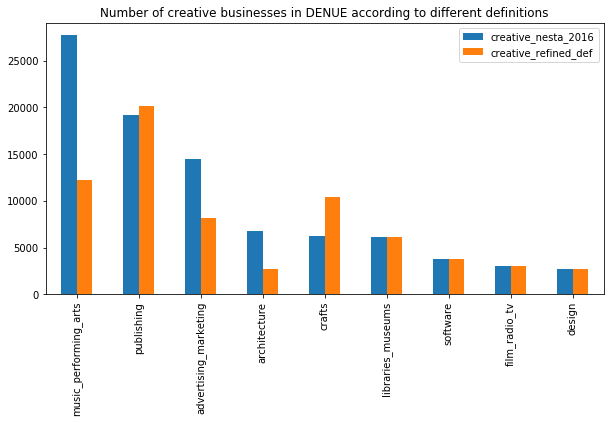

In [468]:
#Compare both:

#We create a table that concatenates both sectors
creative_comp_table = pd.concat([nesta_2016_def['creative_sector'].value_counts(),
                                nesta_ref['creative_sector'].value_counts()],axis=1)

#Rename columns
creative_comp_table.columns=['creative_nesta_2016','creative_refined_def']

#Sort values
creative_comp_table.sort_values('creative_nesta_2016',ascending=False,inplace=True)

#We extract the index of the table to sort charts later
sectors_sorted = creative_comp_table.index


fig,ax = plt.subplots(figsize=(10,5))



creative_comp_table.plot.bar(ax=ax,title='Number of creative businesses in DENUE according to different definitions')

If we look at the `naics_creative_lookup_short` file we can see what explains the differences:

* Music and performing arts in Nesta 2016 includes many generic and sports related educational activities
* Advertising and marketing in Nesta 2016 includes management consulting activities
* Architecture in Nesta 2016 includes engineering and drafting services, building inspection and other things unrelated to architectural design
* Crafts in Nesta 2016 doesn't include several activities related to jewelry and metalwork

As mentioned before, we will focus on the Nesta definition for now. We can change the definition later.

#### How many people work in the sector?

In [469]:
#We call them cis for creative industries
cis = nesta_2016_def.copy()

#Make estado lowercase to match with the map data later
cis['state'] = [x.lower().strip() for x in cis['state']]


In [470]:
#This is the size distribution

size_distribution = pd.DataFrame(cis['employee_sizeband'].value_counts())
size_distribution['share_pc'] = size_distribution/size_distribution.sum()

sizeb_sorted = size_distribution.index

size_distribution

,employee_sizeband,share_pc
0 a 5 personas,68347,0.759377
6 a 10 personas,10324,0.114706
11 a 30 personas,7851,0.087229
31 a 50 personas,1954,0.021710
51 a 100 personas,818,0.009088
101 a 250 personas,446,0.004955
251 y más personas,264,0.002933


In [471]:
#Sizeband by creative subsector compared with the creative industries overall and other sectors

sector_size = pd.crosstab(cis['creative_sector'],cis['employee_sizeband'],normalize=0)


#Now we combine with the size distribution chart above and with a size distribution table *for all companies*

#This creates a sizeband distribution for all businesses in DENUE
sizeband_distr_all= pd.concat([x[2][2] for x in denue_eda_outputs],axis=1).sum(axis=1)

#We calculate shares
sizeband_distr_shares = sizeband_distr_all/sizeband_distr_all.sum()

#Concatenate everything
sector_size_all = pd.concat([sector_size.T,size_distribution['share_pc'],sizeband_distr_shares],axis=1)

#We rename the columns for all creative and other sectors
sector_size_all.rename(columns={'share_pc':'creative_industries',0:'all_sectors'},inplace=True)

#We want to show all creative subsectors first, sorted by their size. 


sectors_sorted = sector_size_all.T.sort_values(['0 a 5 personas'],ascending=True).index

#We put creative industries and all sectors at the end. This is what this list comprehension is for
sectors_sorted = [x for x in sectors_sorted if x not in ['all_sectors','creative_industries']]+[
    'creative_industries','all_sectors']

(-0.5, 14)

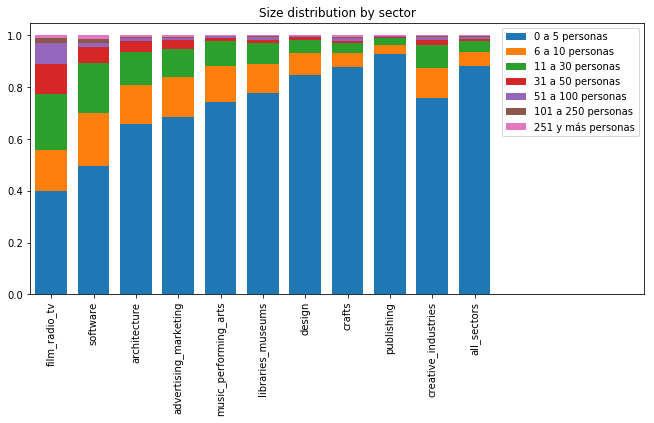

In [472]:
fig,ax = plt.subplots(figsize=(11,5))

sector_size_all.T.loc[sectors_sorted,sizeb_sorted].plot.bar(stacked=True,ax=ax,width=0.75,
                                                      title='Size distribution by sector')

#We adjust limits to fit the legend on the right
ax.set_xlim((-0.5,14))

In [473]:
#Create a midpoint estimate

In [474]:
def get_midpoint(sizeband_value):
    '''
    This function extracts a midpoint estimate from the sizeand variable in the DENUE data
    
    '''
    
    #With the exception of '251 y mas...' the categories say 'x to y' people. We will split on whitespace
    #and extract the values,turn them into integers and average them.
    
    #We assume that the top value is 251. Maybe we could survey these companies to get their employment. Who are they?
    
    if '251' in sizeband_value:
        estimate = 251
        
    else:
        #Split
        split = sizeband_value.split(" ")

        #Get mean
        estimate = np.mean([int(split[0]),int(split[2])])
        
    return(estimate)
        
    

In [475]:
#Here it is
cis['employment_estimate'] = [get_midpoint(x) for x in cis.employee_sizeband]

In [476]:
cis.employment_estimate.sum()

699838.0

This number is significantly lower than what other people say, eg '2m jobs including 'direct and indirect' jobs' according to [this blog](https://www.forbes.com.mx/la-cultura-riqueza-mal-vista/) (Note that it includes no definition). Note that the right-censoring of the data means that we are probably underestimating the size of the companies in DENUE (for example, according to [Wikipedia](https://es.wikipedia.org/wiki/Televisa), Televisa employs 15,000 people but these data would estimate its employmnent at 11.

Maybe we could run the bigger companies vs Wikipedia to extract their employment? What are they?

In [477]:
large_company_list = list(cis.loc[cis.employment_estimate>250,'name'])

In [478]:
large_company_list[:10]

#There is some repetition in the names. Are these different organisations or duplicates?

['RSI HOME PRODUCTS S DE RL DE CV',
 'GRUPO INTERMARMOL SA DE CV',
 'GRUPO INTERMARMOL, S.A. DE C.V.',
 'MARMOLES EL PASO, S.A. DE C.V.',
 'CANTERAS EL DELFIN SA DE CV',
 'MARMOLES INDUSTRIALES CASTRO SA DE CV',
 'GRUPO TENERIFE',
 'MODULAR VANITY TOPS, S. DE R.L.',
 'ABRASIVOS AUSTROMEX, S.A. DE C.V.',
 'COMPAÑIA NACIONAL DE ABRASIVOS SA DE CV']

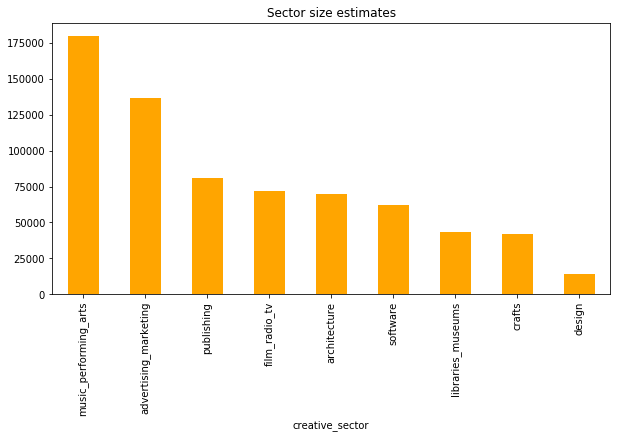

In [479]:
#Create sector size estimates
sector_size_estimates = cis.groupby('creative_sector')['employment_estimate'].sum().sort_values(ascending=False)

fig,ax = plt.subplots(figsize=(10,5))

sector_size_estimates.plot.bar(ax=ax,color='orange',title='Sector size estimates')


#### Comparing employment in CIs with other industries

In [480]:
#This will concatenate business counts in different sizebands for each sector outside of the CIs

all_sizebands = pd.concat([x[2][2] for x in denue_eda_outputs],axis=1).sum(axis=1).reset_index(drop=False)

#We produce the 'midpoint estimate' of the data 
all_sizebands['midpoint'] = [get_midpoint(x) for x in all_sizebands['index']]

#All employment multiplies the midpoint estimate by the number of companies in each sizeband
all_employment = np.sum(all_sizebands['midpoint']*all_sizebands[0])

#We divide the creative employment by all employment to get an estimate

np.round(100*699838.0/all_employment,3)

2.504

2.5% of all estimated employment is in the creative industries

### Other inter-sectoral comparisons







#### Incorporation dates

Date when different organisations joined the register. This isn't the same as company age.

We will look at this by subsector and compared to the creative industries.



In [481]:
#How many incorporation values are there?

cis_join_date = cis.incorp_date.value_counts()

cis_join_date.name='creative_industries'

cis_subsector_join_date = pd.crosstab(cis.incorp_date,cis.creative_sector)

#How do they compare with the data for all other sectors?
#As previously, we extract the information from the denue outputs container and sum to
#get total number of companies by date of incorporation into the register 

all_join_date = pd.concat([x[2][3] for x in denue_eda_outputs],axis=1).sum(axis=1)
all_join_date.name='all_sectors'


#Let's put everything together

#We want to sort the dates from the oldest to the newest
merged_join_date =pd.concat([cis_subsector_join_date,cis_join_date,all_join_date],axis=1).reset_index(drop=False)

#Combine inclusion dates by year
merged_join_date['year'] = [int(x.split(" ")[1]) for x in merged_join_date['index']]

#Sum by year and reindex
merged_join_date = merged_join_date.drop('index',axis=1).groupby('year').sum().apply(lambda x: x/x.sum(),axis=0)

#Sort sectors by 'novelty' (Importance of incorporations in 2014 - 2016) with all_sectors and creative_industries
#at the end
sectors_sorted_date = merged_join_date.T.iloc[:,-2:].sum(axis=1).sort_values(ascending=False).index

sectors_sorted_date = [x for x in sectors_sorted_date if x not in [
    'creative_industries','all_sectors']] + ['creative_industries','all_sectors']

(-0.5, 12.2)

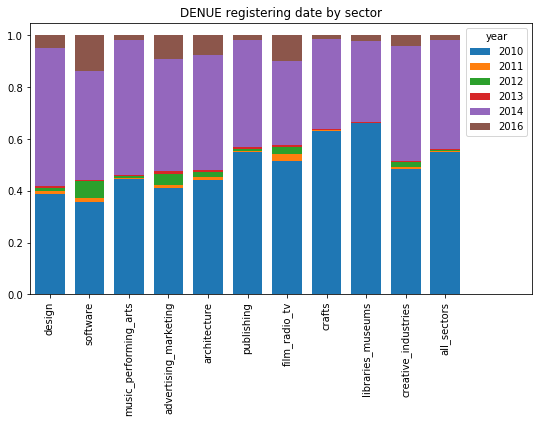

In [482]:
fig,ax = plt.subplots(figsize=(9,5))

merged_join_date.T.loc[sectors_sorted_date,:].plot.bar(stacked=True,ax=ax,width=0.75,
                                                      title='DENUE registering date by sector')

#We adjust limits to fit the legend on the right
ax.set_xlim((-0.5,12.2))

(-0.5, 7.5)

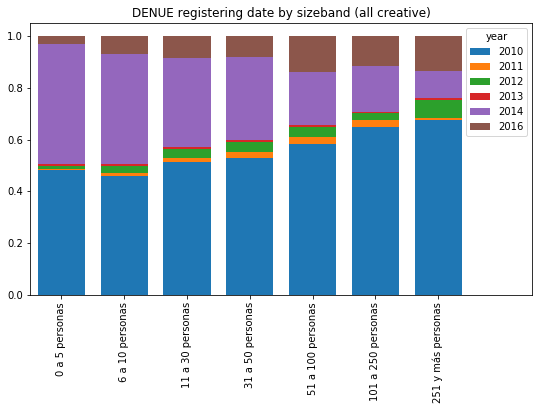

In [483]:
#Finally, check incorporation dates by size

#Crosstab
inc_dates_size = pd.crosstab(cis.incorp_date,cis.employee_sizeband,normalize=1).loc[:,sizeb_sorted]

#As before, we extract the year from the incorporation variable so we can aggregate and sort more easily
inc_dates_size['year'] = [int(x.split(" ")[1]) for x in inc_dates_size.index]


fig,ax = plt.subplots(figsize=(9,5))

inc_dates_size.groupby('year').sum().T.plot.bar(stacked=True,ax=ax,width=0.75,
                                                      title='DENUE registering date by sizeband (all creative)')

#We adjust limits to fit the legend on the right
ax.set_xlim((-0.5,7.5))

This is kind of surprising - many larger companies have been added to the data in recent years. Let's check some of them

In [484]:
cis.loc[(['2016' in x for x in cis['incorp_date']]) & (cis.employment_estimate>250),:].head()

,id,name,legal_name,sector,sector_description,employee_sizeband,postcode,state,municipality,location,...,website,type_organisation,lat,lon,incorp_date,creative_nesta_2016,creative_refined,creative_sector,has_creative,employment_estimate
1879,6769819,GRUPO TENERIFE,OPERADORA TOLEDO SAPI DE CV,327991,Fabricación de productos a base de piedras de ...,251 y más personas,66480.0,nuevo león,San Nicolás de los Garza,San Nicolás de los Garza,...,NaN,Fijo,25.708577,-100.281325,OCTUBRE 2016,1.0,1.0,crafts,1,251.0
6368,6750731,LEGO OPERACIONES DE MÉXICO SA DE CV,LEGO OPERACIONES DE MEXICO SA DE CV,339930,Fabricación de juguetes,251 y más personas,65580.0,nuevo león,General Zuazua,San Ignacio,...,WWW.LEGO.COM,Fijo,25.887995,-100.231178,OCTUBRE 2016,1.0,1.0,crafts,1,251.0
10454,6774890,MICROSOFT MEXICO,MICROSOFT MEXICO S DE RL DE CV,511210,Edición de software y edición de software inte...,251 y más personas,1376.0,distrito federal,Álvaro Obregón,Álvaro Obregón,...,WWW.MICROSOFT.COM,Fijo,19.366606,-99.264499,OCTUBRE 2016,1.0,1.0,software,1,251.0
17703,6509033,CANAL 4,"COMUNICACION DEL SURESTE, S.A. DE C.V.",515120,Transmisión de programas de televisión,251 y más personas,30796.0,chiapas,Tapachula,Tapachula de Córdova y Ordóñez,...,NaN,Fijo,14.887901,-92.284787,ENERO 2016,1.0,1.0,film_radio_tv,1,251.0
17762,6503428,MVS NET SA DE CV,MVS NET SA DE CV,515120,Transmisión de programas de televisión,251 y más personas,15530.0,distrito federal,Venustiano Carranza,Venustiano Carranza,...,WWW.MVSTELEVISION.COM,Fijo,19.433883,-99.088800,ENERO 2016,1.0,1.0,film_radio_tv,1,251.0


Overall the numbers are small (36)

#### Where is the sector?

We will examine its geography in terms of:
* Total levels of activity by state and municipality, and totals by subsector
* Values normalised by activity in other industries

In [485]:
#Let's end the day with a map

#Distribution of businesses by state
state_creative_counts = cis['state'].value_counts()

#Remember we loaded the estado shapefile before. We make the estate name lowercases to merge on them
estados['NOM_ENT'] = [x.lower().strip() for x in estados['NOM_ENT']]

#They also use different names for Mexico City (DENUE calls it distrito federal and 
#the shapefiles call it Ciudad de Mexico. 
#We fix hackily

estados['NOM_ENT'] = ['distrito federal' if x =='ciudad de méxico' else x for x in estados['NOM_ENT']]

#Merge them
state_creative_polys = pd.merge(estados,state_creative_counts.reset_index(drop=False),left_on='NOM_ENT',
                               right_on='index')

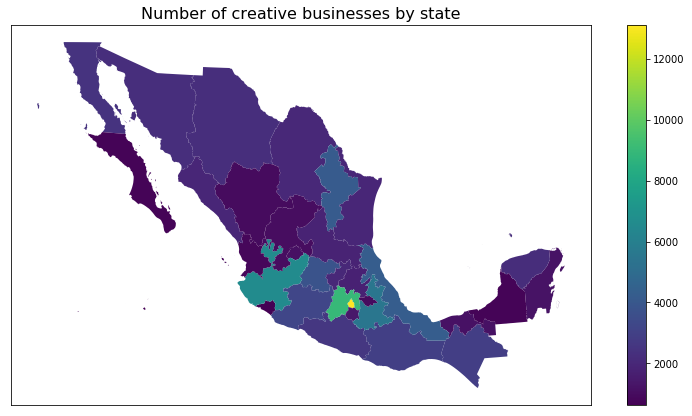

In [486]:
fig,ax = plt.subplots(figsize=(13,7))

state_creative_polys.plot('state',ax=ax,cmap='viridis',legend=True)

ax.set_title('Number of creative businesses by state',size=16)

#Set axis off
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [487]:
# Let's calculate measures of specialisation

#This function calculates LQs

#Functions
def create_lq_df(df,year=None):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    
    if year!=None:
        lqs['period'] = year
    
    return(lqs)

In [488]:
def process_counts_to_get_lqs(subsector_df,creative_df,all_sectors_df):
    '''
    This function takes a subsector df, creative df and all sectors df
    and operates on them to return a creative LQ df. 
    
    '''
    
    creative_all_state = pd.concat([creative_df,all_sectors_df],axis=1)
    creative_all_state.columns=['creative_industries','all_industries']

    creative_all_state['not_creative'] =creative_all_state['all_industries'] - creative_all_state['creative_industries']
    
    
    #Now we have everything we need to calculate the LQ
    #We use the function we defined above. We combine creative data with 
    #not creative to normalise over the total in the locality.
    #NB we drop not creative at the end because we don't plan to report it.

    creative_subsector_state_lq,creative_industries_state_lq = [
        create_lq_df(pd.concat([x,creative_all_state['not_creative']],axis=1)).drop('not_creative',axis=1) for
        x in [subsector_df,creative_df]]

    #Now we combine the subsector and industry data for mapping

    creative_state_lq = pd.concat([creative_industries_state_lq,creative_subsector_state_lq],axis=1)

    creative_state_lq.rename(columns={0:'all_creative'},inplace=True)

    return(creative_state_lq)


#We could probably put this function in the previous class to keep things tidy
def get_state_employment_estimates(df):
    '''
    This function extracts, for each state-size distribution table,
    an estimate of employment based on company sizebands
    '''
    
    #We melt the dataframe to simplify processing
    #We need to reset the index to use it as the id var when melting
    df_melted = pd.melt(df.reset_index(drop=False),id_vars='state')
    
    df_melted['midpoint'] = [get_midpoint(x) for x in df_melted['employee_sizeband']]
    
    #Multiply the midpoint by number of businesses
    df_melted['employment_estimate'] = df_melted['midpoint']*df_melted['value']
    
    #Regroup
    df_aggregate = df_melted.groupby('state')['employment_estimate'].sum()
    
    return(df_aggregate)


In [489]:
#We create a wide table with creative company counts by state and creative sector

#This simply pivots a grouped df where we counted the number of unique ids in every state-sector combination
creative_subsector_state = pd.pivot_table(
    cis.groupby(['state','creative_sector'])['id'].count().reset_index(drop=False),
    index='state',
    columns='creative_sector',values='id')

creative_subsector_state.head()

#Also calculate the total CIs per state, summing over the rows above
creative_industries_state =creative_subsector_state.sum(axis=1)

In [490]:
#And now we combine this with the total counts by sector

#All state counts
#Concatenate and sum the company counts we extracted before
all_state = pd.concat([x[2][0] for x in denue_eda_outputs],axis=1).sum(axis=1)

#Make the index lowercase for merging
#We also need to remove trailing whitespaces 
all_state.index = [x.lower().strip() for x in all_state.index]

creative_state_lq = process_counts_to_get_lqs(creative_subsector_state,creative_industries_state,all_state)

In [491]:
creative_state_lq.head()

,all_creative,advertising_marketing,architecture,crafts,design,film_radio_tv,libraries_museums,music_performing_arts,publishing,software
state,,,,,,,,,,
aguascalientes,1.101123,1.235864,1.426853,0.697184,2.064779,0.666773,0.683274,1.142952,0.922782,1.604912
baja california,1.168069,1.223875,1.531995,0.668793,1.304745,1.529529,0.773989,1.201122,1.158772,1.177308
baja california sur,1.191771,1.372960,1.912879,0.537308,1.291483,1.523158,1.646990,1.307297,0.723293,0.736276
campeche,1.028936,0.969590,1.732513,0.180297,0.876763,1.632699,1.105317,1.148174,0.861818,0.863995
chiapas,0.859626,0.729162,0.688216,0.250762,0.616783,1.160418,1.037897,1.218941,0.736913,0.303159


In [492]:
state_creative_lqs_polys = pd.merge(estados,creative_state_lq.reset_index(drop=False),left_on='NOM_ENT',
                               right_on='state')

In [493]:
def plot_map(polygon_df,sector,discretised=False,ax=ax):
    '''
    This function takes a polygon df and a variable and returns a map. We can ask it to discretise the data
    into deciles too. 
    
    '''
    
    #If we want to discretise the data we transform the sector variable into deciles
    if discretised!=False:
        polygon_df[sector]= pd.qcut(polygon_df[sector],q=np.arange(0,1.1,0.1),
                                    labels=False,duplicates='drop')
        
    polygon_df.plot(sector,ax=ax,cmap='bwr',legend=False,edgecolor='black',
                                 linewidth=0.5)

    ax.set_title('{x}'.format(x=sector),size=16)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    
        

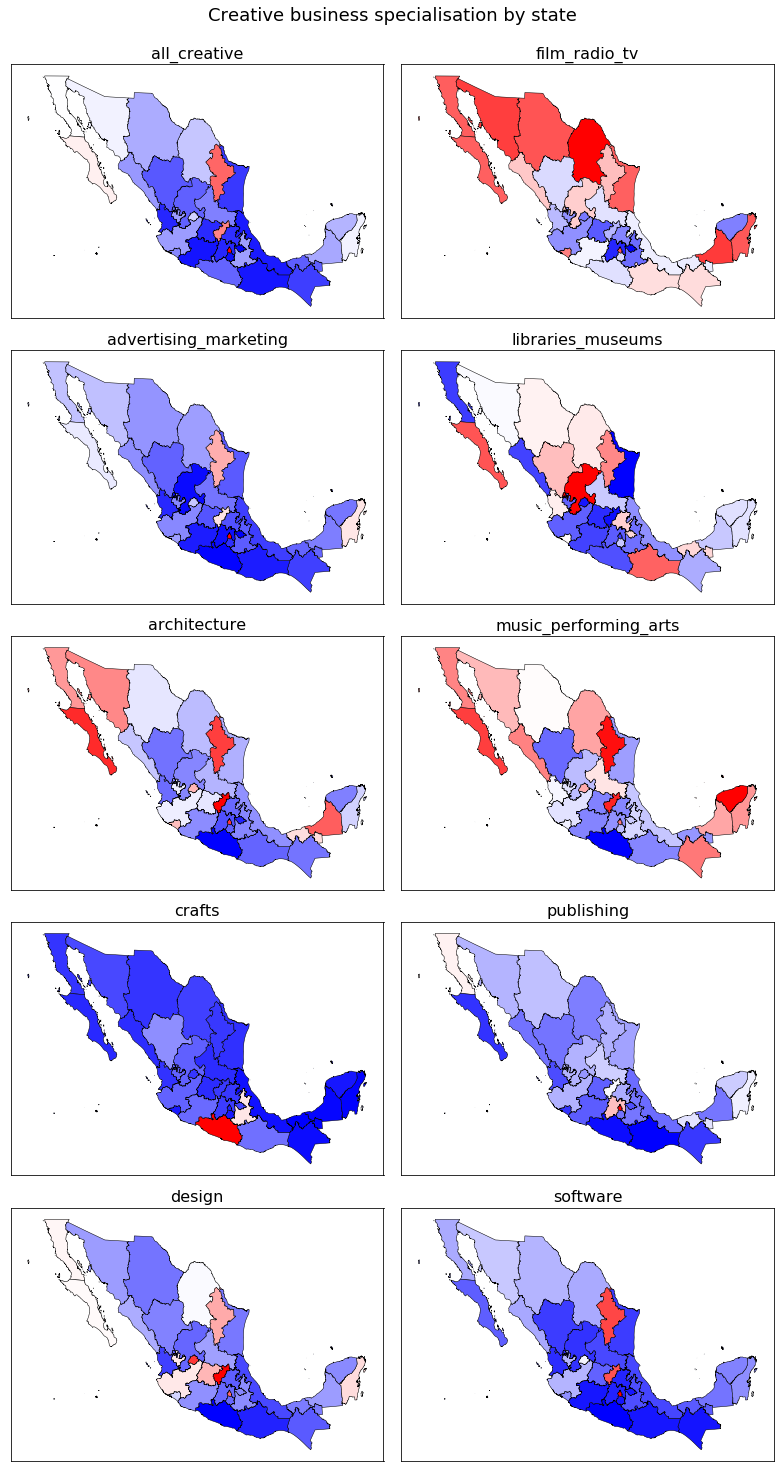

In [494]:
#And then we map
#NB We haven't added legends yet - 
#the graphs are not strictly comparable because the color-scale is set based on the distribution for each variable

fig,ax = plt.subplots(figsize=(11,20),nrows=5,ncols=2)

for num,sector in enumerate(creative_state_lq.columns):
    
    if num<5:
        col=0
        row=num
    else:
        col=1
        row=num-5
    
    plot_map(polygon_df=state_creative_lqs_polys,sector=sector,ax=ax[row][col])
    
fig.suptitle('Creative business specialisation by state',y=1.02,size=18)

plt.tight_layout()


In [495]:
# Need to do something similar with employment.

#Create employment LQs
#Get employment estimates by subsector
cr_subsector_employment_state = pd.pivot_table(cis.groupby(
    ['state','creative_sector'])['employment_estimate'].sum().reset_index(drop=False),
                                               index='state',
                                               columns='creative_sector',
                                               values='employment_estimate')

#Get creative industries employment
all_creative_employment_state = cr_subsector_employment_state.sum(axis=1)

#We would also need to get employment estimates by location
all_sectors_employment_state = pd.concat(
    [get_state_employment_estimates(x[2][4]) for x in denue_eda_outputs],axis=1).sum(axis=1)

all_sectors_employment_state.index = [x.lower().strip() for x in all_sectors_employment_state.index]

#Same as we did before, using the function to process creative dfs into lqs
creative_state_lq_emp =process_counts_to_get_lqs(cr_subsector_employment_state,all_creative_employment_state,
                                                all_sectors_employment_state)

#And merge with polygons for mapping
state_creative_emp_lqs_polys = pd.merge(estados,creative_state_lq_emp.reset_index(drop=False),left_on='NOM_ENT',
                               right_on='state')



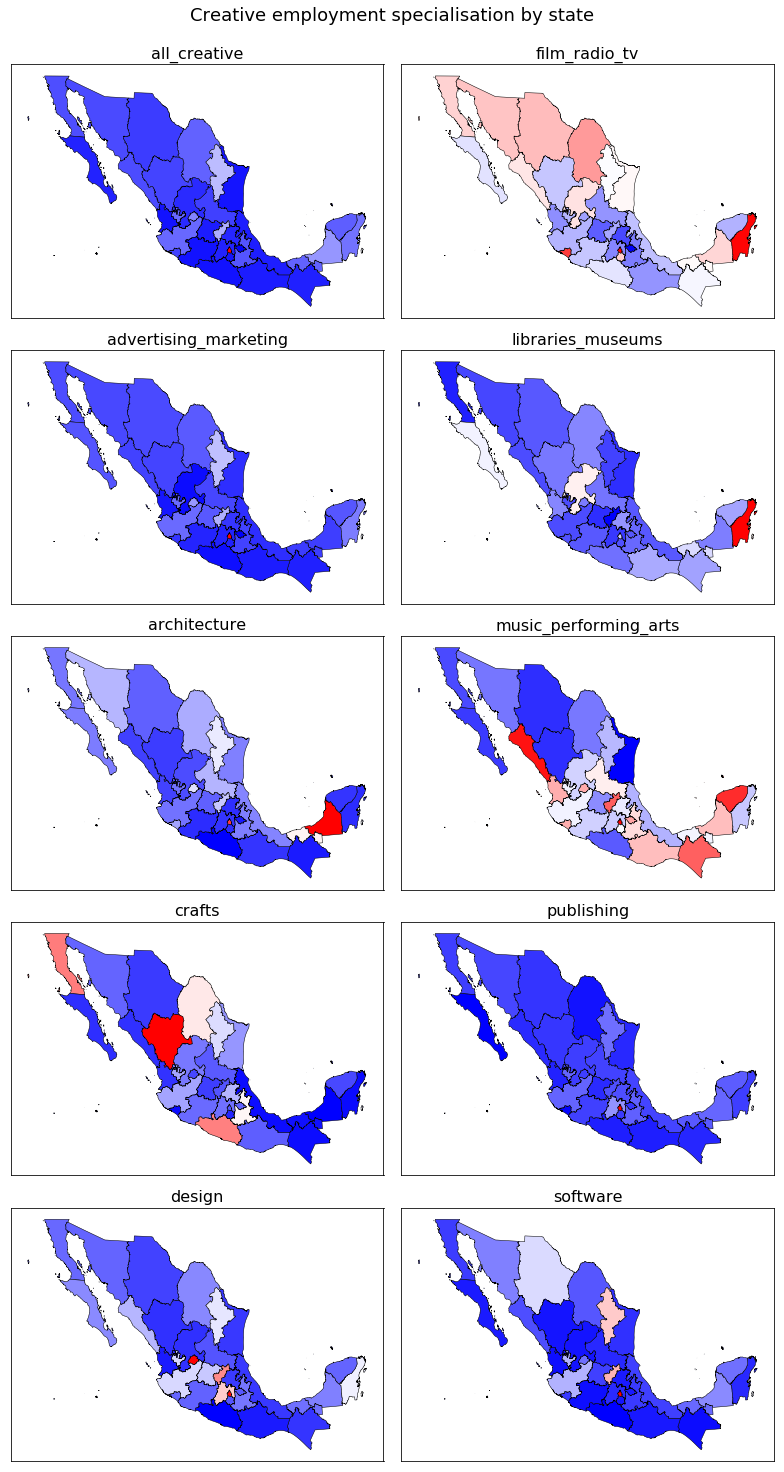

In [496]:
#And then we map.
#Still no legend

fig,ax = plt.subplots(figsize=(11,20),nrows=5,ncols=2)

for num,sector in enumerate(creative_state_lq_emp.columns):
    
    if num<5:
        col=0
        row=num
    else:
        col=1
        row=num-5
    
    plot_map(polygon_df=state_creative_emp_lqs_polys,sector=sector,ax=ax[row][col])
    
fig.suptitle('Creative employment specialisation by state',y=1.02,size=18)

plt.tight_layout()


A lot of concentration in Mexico DF and Nuevo León with some exceptions like Film Radio and TV in the North or Durango and Guerrero in Crafts

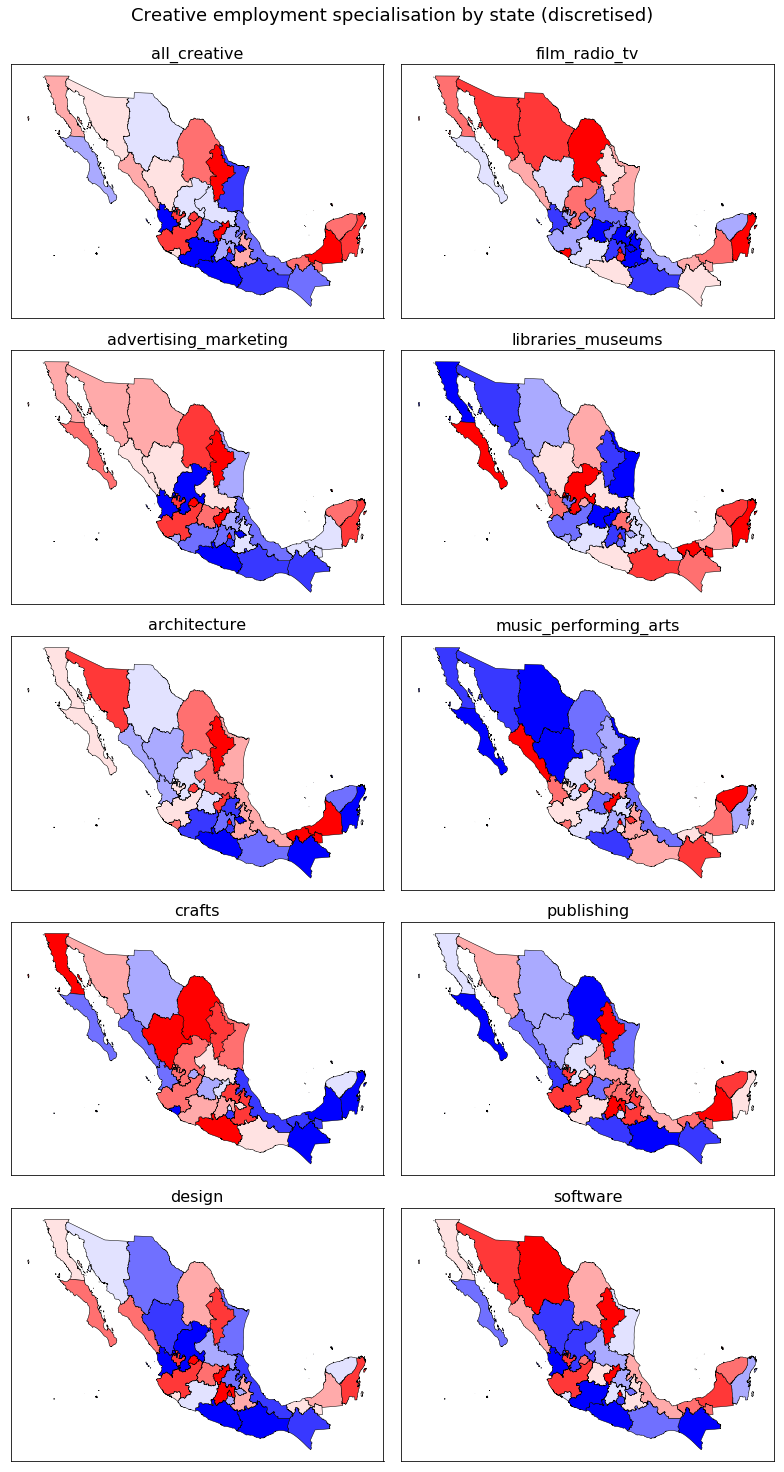

In [497]:
#Here we are discretising each LQ distribution we plot (bin it in its decile)
#Colours for states are comparable (everywhere is binned into deciles)

fig,ax = plt.subplots(figsize=(11,20),nrows=5,ncols=2)

for num,sector in enumerate(creative_state_lq_emp.columns):
    
    if num<5:
        col=0
        row=num
    else:
        col=1
        row=num-5
    
    plot_map(polygon_df=state_creative_emp_lqs_polys,sector=sector,ax=ax[row][col],discretised=True)
    
fig.suptitle('Creative employment specialisation by state (discretised)',y=1.02,size=18)

plt.tight_layout()


Interesting - does this suggest some trans-state clusters?

## Contact detail availability

To conclude our initial exploration of DENUE data, we have a look at the availability of contact details for companies.

* How many have addresses (we will simply count postcodes)
* How many have telephones?
* How many have email addresses?


In [505]:
#We import product to calculate the cartesian product of variables

from itertools import product

In [498]:
#We will create a reduced dataframe with the variables we are interested in: 
#(contact and company characteristics relevant for the survwt)

#Select contact variables

#Contact variables
contact_vars = ['postcode','telephone','email']

#Metadata for analysis
metadata_vars = ['employee_sizeband','creative_sector','state']

#Create reduced df
contact_cis = cis[contact_vars+metadata_vars]

In [503]:
#How many have postcode, telephone and email?

contact_cis[contact_vars].apply(lambda x: x.isna()==False).mean()

#We have postal addresses for everyone, telephone for 55% and email for 22%

postcode     0.990800
telephone    0.567097
email        0.227890
dtype: float64

In [534]:
#This list comprehension creates a dict where the keys are the variables we are considering and the 
#values are the cross-tabs between each category and availability of contact details.
# We don't consider postal addresses because those are available for almost everyone.

cross_tabs = {x+'_'+y:pd.crosstab(contact_cis[x],contact_cis[y].isna()==False,normalize=0) for x,y in 
              product(metadata_vars,['telephone','email'])}



Text(0.5,1.02,'Availability contact details by Company size / sector / State')

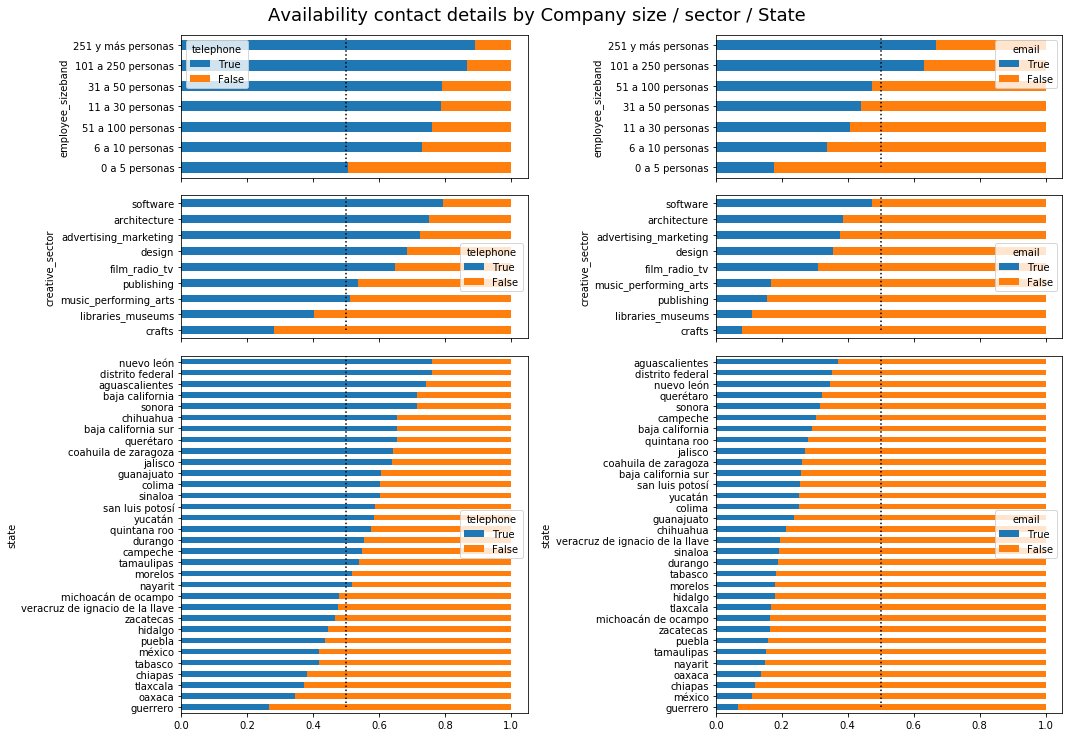

In [597]:
#Plot contact details

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(15,10),gridspec_kw={'height_ratios':[2,2,5]},sharex='col')

#Go through the metadata variables we are interested in (eg sizeband, sector, state)    
for num,x in enumerate(metadata_vars):
    
    #Select the right cross tabs
    x = [v for k,v in cross_tabs.items() if x in k]
    
    #Loop over them
    for ct in x:
        #We make sure everything comes out in the right order by checking the name of the contact variable
        
        
        #The telephone crosstabs will always be in the left column
        if ct.columns.name=='telephone':
            
            #NB we are sorting the rows so that the places with most availability are at the top
            ct.sort_values(True,ascending=True).iloc[:,[1,0]].plot.barh(ax=ax[num][0],stacked=True)
                
            #We add a vertical line in the 50%
            ax[num][0].vlines(x=0.5,ymin=0,ymax=len(ct),linestyle=':')
    
        #The email crosstabs will always be in the right column
        else:
            ct.sort_values(True,ascending=True).iloc[:,[1,0]].plot.barh(ax=ax[num][1],stacked=True)
            
            ax[num][1].vlines(x=0.5,ymin=0,ymax=len(ct),linestyle=':')
    
#Thig layout    
plt.tight_layout()

#name
fig.suptitle('Availability contact details by Company size / sector / State',y=1.02,size=18)

In [667]:
#We conclude with a couple of heatmaps
contact_cis['has_telephone'] = contact_cis.telephone.isna()==False
contact_cis['has_email'] = contact_cis.email.isna()==False


contact_cross = [pd.pivot_table(
    contact_cis.groupby(['creative_sector','state'])[x].mean().reset_index(drop=False),
    index='creative_sector',columns='state',values=x) for x in ['has_telephone','has_email']]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [670]:
def make_hm(ct,ax=ax):
    '''
    Takes a crosstab and returns a heatmap
    
    '''
    #Extracts the sectors and states sorted
    
    sectors_contact_sorted = ct.mean(axis=1).sort_values(ascending=False).index
    states_contact_sorted = ct.mean(axis=0).sort_values(ascending=False).index

    #Plots
    ims = ax.imshow(ct.loc[sectors_contact_sorted,states_contact_sorted],cmap='seismic',aspect='auto',
                   vmax=1,vmin=0)

    #Creates the axis labels 
    ax.set_yticks(np.arange(len(ct.index)))
    ax.set_yticklabels(sectors_contact_sorted)
    ax.set_xticks(np.arange(len(ct.columns)))
    ax.set_xticklabels(states_contact_sorted,rotation=45,ha='right')
    
    #Draw the color bar
    fig.colorbar(ims,ax=ax)

    return(ims)
    

Text(0.5,1,'Contact availability: Email by state and sector')

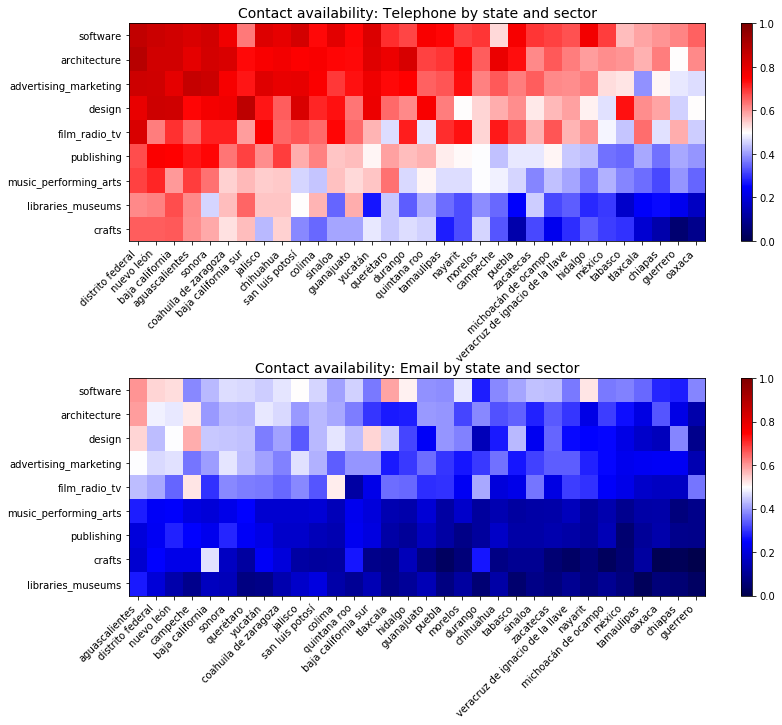

In [675]:
fig,ax = plt.subplots(figsize=(12,10),nrows=2)

make_hm(contact_cross[0],ax=ax[0])
make_hm(contact_cross[1],ax=ax[1])

plt.tight_layout()

ax[0].set_title('Contact availability: Telephone by state and sector',size=14)
ax[1].set_title('Contact availability: Email by state and sector',size=14)
